# Curvenote demo - analysis notebook

In this jupyter notebook, we will show the basic functions of curvenote by running some simple analyses on the penguin data set. 

In [31]:
# Import required libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm


## The penguin data set
Just for the sake of the example, we will load the penguin data set from seaborn. We will then run some simple analyses to illustrate how to generate figures and tables that we can then link in our paper (markdown file)

In [32]:
# Step 1: Load the Palmer Penguins dataset
# Seaborn provides a direct function to load the dataset
penguins = sns.load_dataset('penguins')

# Step 2: Display the first few rows of the dataset and some information about the data frame
print(f"N Penguins: {penguins.shape[0]}")
print("First few rows of the dataset:")
print(penguins.head())

# Step 3: remove nans:
penguins_clean = penguins.dropna()
print(f"N Penguins after clean up: {penguins_clean.shape[0]}")




N Penguins: 344
First few rows of the dataset:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  
N Penguins after clean up: 333


In [33]:
# Step 4: Print summary statistics
penguins_clean.describe(include='all')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,333,333,333.000000,333.000000,333.000000,333.000000,333
unique,3,3,NaN,NaN,NaN,NaN,2
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,Male
freq,146,163,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.992793,17.164865,200.966967,4207.057057,NaN
std,NaN,NaN,5.468668,1.969235,14.015765,805.215802,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.500000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.500000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.600000,18.700000,213.000000,4775.000000,NaN


In [34]:
# Step 5: print covariance between variables
numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
covariance_matrix = penguins_clean[numerical_cols].cov()
print("\nCovariance:")
covariance_matrix


Covariance:


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,29.906333,-2.462091,50.058195,2595.623304
bill_depth_mm,-2.462091,3.877888,-15.947248,-748.456122
flipper_length_mm,50.058195,-15.947248,196.441677,9852.191649
body_mass_g,2595.623304,-748.456122,9852.191649,648372.487699


In [35]:
# Step 6: print correlations between variables
print('Correlation:')
correlation_matrix = penguins_clean[numerical_cols].corr()
print("\nCorrelation Matrix:")
correlation_matrix

Correlation:

Correlation Matrix:


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.228626,0.653096,0.589451
bill_depth_mm,-0.228626,1.000000,-0.577792,-0.472016
flipper_length_mm,0.653096,-0.577792,1.000000,0.872979
body_mass_g,0.589451,-0.472016,0.872979,1.000000


<Axes: xlabel='species'>

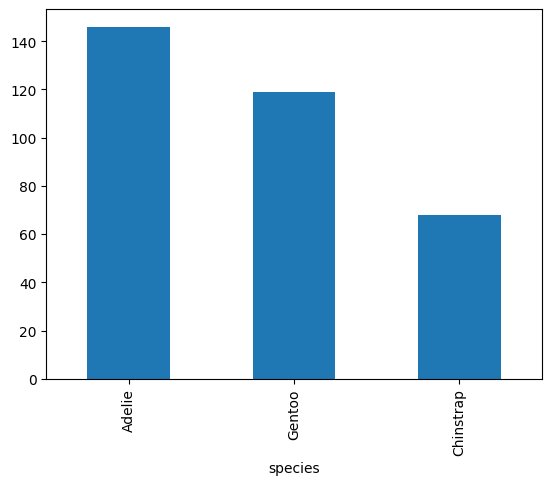

In [36]:
# Step 7: plot the counts per species:
penguins_clean['species'].value_counts().plot(kind="bar")

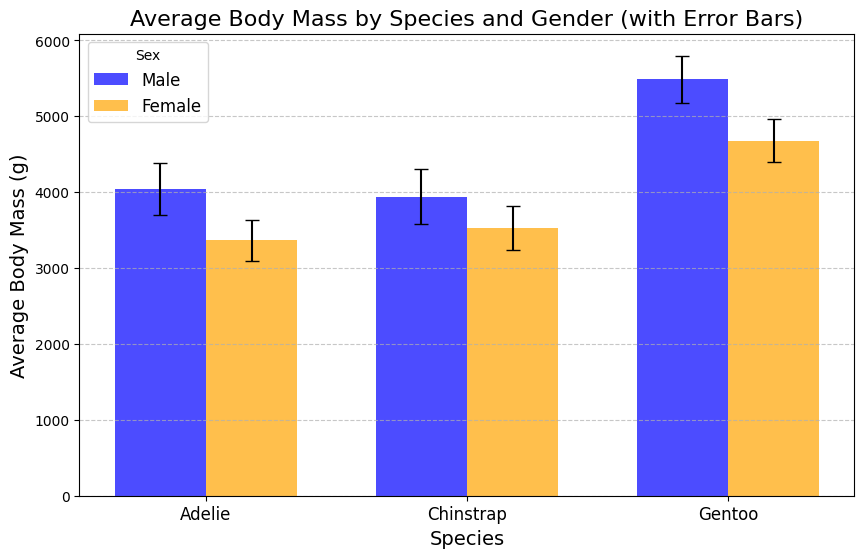

In [37]:
#| label: PenguinWeight

# Step 8: plot the weight of each species
grouped_data = penguins_clean.groupby(['species', 'sex'])['body_mass_g'].agg(['mean', 'std']).unstack()
# Extract means and SEMs
species = grouped_data.index
male_means = grouped_data[('mean', 'Male')]
female_means = grouped_data[('mean', 'Female')]
male_sems = grouped_data[('std', 'Male')]
female_sems = grouped_data[('std', 'Female')]

x = range(len(species))  # Positions for each species

# Step 4: Plot with error bars
plt.figure(figsize=(10, 6))
bar_width = 0.35

# Plot bars with error bars
plt.bar(x, male_means, yerr=male_sems, width=bar_width, label='Male', alpha=0.7, color='blue', capsize=5)
plt.bar([p + bar_width for p in x], female_means, yerr=female_sems, width=bar_width, label='Female', alpha=0.7, color='orange', capsize=5)

# Step 5: Customize the plot
plt.xlabel('Species', fontsize=14)
plt.ylabel('Average Body Mass (g)', fontsize=14)
plt.title('Average Body Mass by Species and Gender (with Error Bars)', fontsize=16)
plt.xticks([p + bar_width / 2 for p in x], species, fontsize=12)
plt.legend(title='Sex', fontsize=12)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

#plt.tight_layout()
plt.show()

# Investigate the relationship between penguin beak lengths and their weights separately for each species using optimal least square multiple regression


In [38]:
#| label: OLSResults

import statsmodels.formula.api as smf
# Compute the regression between the body mass, bill length and species:
model = smf.ols('body_mass_g ~ bill_length_mm + bill_length_mm:species', data=penguins).fit()

# Format the results to a dataframe:
summary_df = pd.DataFrame({
    "Coefficient": model.params,
    "Standard Error": model.bse,
    "Lower CI": model.conf_int()[0],
    "Upper CI": model.conf_int()[1],
    "P-Value": model.pvalues
}).reset_index().rename(columns={"index": "Regressor"})
summary_df.round(3)


,Regressor,Coefficient,Standard Error,Lower CI,Upper CI,P-Value
0,Intercept,147.413,300.627,-443.924,738.749,0.624
1,bill_length_mm,91.612,7.753,76.363,106.862,0.000
2,bill_length_mm:species[T.Chinstrap],-18.252,1.992,-22.170,-14.334,0.000
3,bill_length_mm:species[T.Gentoo],12.161,1.759,8.702,15.620,0.000


In [39]:
#| label: ANOVAResults
# Compute the first level anova:
anova_table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA DataFrame
anova_table.round(3)

,sum_sq,df,F,PR(>F)
bill_length_mm,7.766907e+07,1.0,562.798,0.0
bill_length_mm:species,9.499284e+07,2.0,344.164,0.0
Residual,4.664579e+07,338.0,NaN,NaN


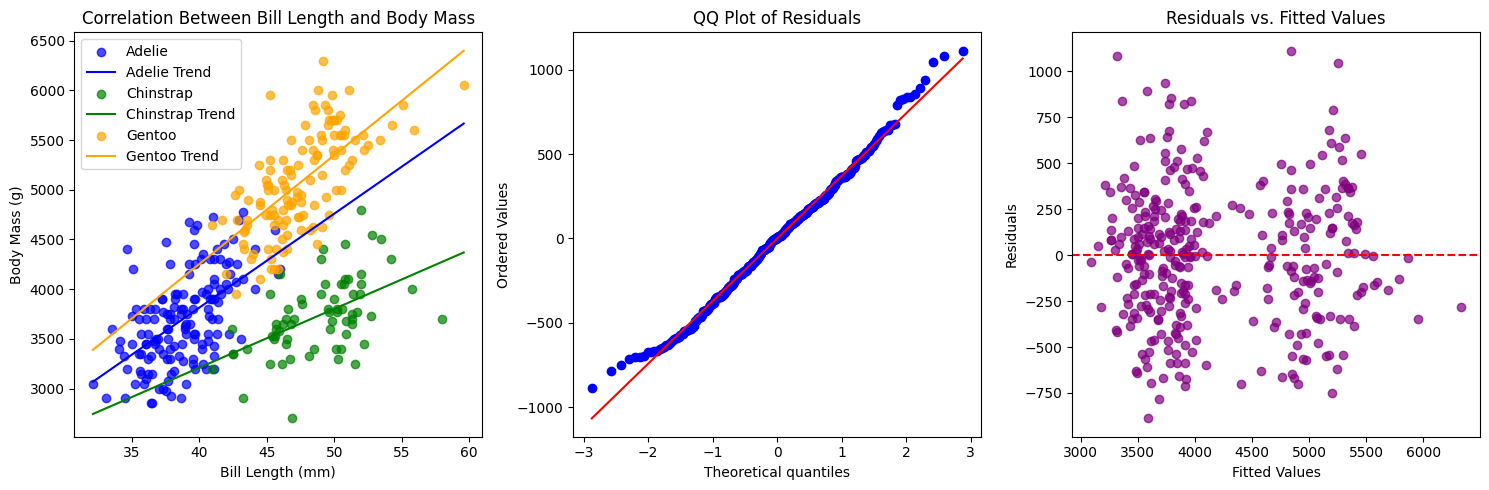

In [40]:
#| label: PenguinCorrelation

# Extract additional info from the model:
residuals = model.resid
fitted_values = model.fittedvalues
x_range = np.linspace(penguins['bill_length_mm'].min(), penguins['bill_length_mm'].max(), 100)

# Plot the results:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# Plot 1: Correlation between bill length and body mass with individual points and average trend
colors = {'Adelie': 'blue', 'Chinstrap': 'green', 'Gentoo': 'orange'}
for species, group in penguins.groupby('species'):
    axs[0].scatter(group['bill_length_mm'], group['body_mass_g'], label=f'{species}', color=colors[species], alpha=0.7)
    species_model = smf.ols('body_mass_g ~ bill_length_mm', data=group).fit()
    axs[0].plot(
        x_range,
        species_model.params.iloc[0] + species_model.params.iloc[1] * x_range,
        color=colors[species],
        label=f'{species} Trend'
    )
axs[0].set_title('Correlation Between Bill Length and Body Mass')
axs[0].set_xlabel('Bill Length (mm)')
axs[0].set_ylabel('Body Mass (g)')
axs[0].legend()

# Plot 2: QQ Plot of residuals
stats.probplot(residuals, dist="norm", plot=axs[1])
axs[1].get_lines()[1].set_color('red')  # Make the trend line red
axs[1].set_title('QQ Plot of Residuals')

# Plot 3: Residuals vs. Fitted Values (Assumption check for homoscedasticity)
axs[2].scatter(fitted_values, residuals, alpha=0.7, color='purple')
axs[2].axhline(0, color='red', linestyle='--')
axs[2].set_title('Residuals vs. Fitted Values')
axs[2].set_xlabel('Fitted Values')
axs[2].set_ylabel('Residuals')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()